In [1]:
import os
import random
import torch
import numpy as np
import pickle as pkl
from analysis import *
import argparse
from sys import platform
%load_ext autoreload
%autoreload 2

In [2]:
torch.manual_seed(12)
torch.cuda.manual_seed(12)
np.random.seed(12)
torch.backends.cudnn.deterministics = True
torch.set_num_threads(1)

In [3]:
print(torch.cuda.is_available())
print(torch.cuda.device_count())
print(torch.cuda.current_device())


print(torch.cuda.device(0))
print(torch.cuda.get_device_name(0))

True
2
0
NVIDIA GeForce RTX 3090


In [4]:
# iv: image option
length = 440
channel = 128
min_CNN = 200
n_classes = 40
classes = range(n_classes)


In [5]:
if platform == "linux" or platform == "linux2":
    torch_models_dir = r"/media/mountHDD1/LanxHuyen/CVPR2017"
elif platform == "win32":
    torch_models_dir = r"D:\Data\CVPR2021-02785\CVPR2021-02785\preprocessed\torch_models"
block_splits_all = '/media/mountHDD1/LanxHuyen/CVPR2017/block_splits_by_image_all.pth' 
eeg_raw = '/media/mountHDD1/LanxHuyen/CVPR2017/eeg_55_95_std.pth'
# block_splits_all, block_splits_single, eeg_14_70, eeg_55_95, eeg_5_95, eeg_raw = os.listdir(torch_models_dir)
# print(os.listdir(torch_models_dir))

In [6]:
# eeg_dataset = os.path.join(torch_models_dir, eeg_5_95)
# splits_all_path = os.path.join(torch_models_dir, block_splits_all)
eeg_dataset = eeg_raw
splits_all_path = block_splits_all

print(eeg_dataset,'\n', splits_all_path)

/media/mountHDD1/LanxHuyen/CVPR2017/eeg_55_95_std.pth 
 /media/mountHDD1/LanxHuyen/CVPR2017/block_splits_by_image_all.pth


In [7]:
splits_all = torch.load(splits_all_path)
# splits_single = torch.load(splits_single_path)

In [8]:
print(len(splits_all['splits']))
print(len(splits_all['splits'][0]))

print(len(splits_all['splits'][5]['train']))
print(len(splits_all['splits'][5]['val']))
print(len(splits_all['splits'][5]['test']))
print(splits_all['splits'][0]['train'][:40])
print(splits_all['splits'][1]['train'][:40])
print(splits_all['splits'][2]['train'][:10])
print(splits_all['splits'][3]['train'][:10])


6
3
7984
1996
1985
[0, 3, 4, 5, 6, 8, 9, 10, 11, 12, 13, 15, 16, 17, 18, 19, 21, 22, 23, 24, 25, 27, 29, 33, 35, 36, 37, 38, 39, 42, 43, 44, 45, 46, 47, 48, 51, 52, 54, 55]
[1, 2, 3, 4, 6, 8, 9, 12, 13, 20, 25, 26, 27, 28, 30, 32, 33, 35, 37, 38, 39, 40, 44, 45, 46, 50, 52, 54, 56, 58, 59, 60, 62, 65, 68, 72, 73, 74, 76, 81]
[2, 3, 4, 5, 6, 7, 8, 10, 11, 13]
[1, 2, 4, 7, 9, 10, 12, 13, 14, 15]


In [9]:
eeg_loaded = torch.load(eeg_dataset)
dataset, labels, images = [eeg_loaded[k] for k in eeg_loaded.keys()]
print(len(eeg_loaded))
print(eeg_loaded.keys())
print(len(labels))
print(len(images))
print(len(dataset))
print(*labels)
print(images[0])
print(dataset[0]['eeg'].shape)
print(dataset[1950])
#Trial 0-1995 - subject 4
#Trial 1996 - 3980 - subject 1
#Trial 3981 - 5976 - subject 6
#Trial 5977 - 7972 - subject 3
#Trial 7973 - 9968 - subject 2
#Trial 9969 - 11964 - subject 5

3
dict_keys(['dataset', 'labels', 'images'])
40
1996
11965
n02389026 n03888257 n03584829 n02607072 n03297495 n03063599 n03792782 n04086273 n02510455 n11939491 n02951358 n02281787 n02106662 n04120489 n03590841 n02992529 n03445777 n03180011 n02906734 n07873807 n03773504 n02492035 n03982430 n03709823 n03100240 n03376595 n03877472 n03775071 n03272010 n04069434 n03452741 n03792972 n07753592 n13054560 n03197337 n02504458 n02690373 n03272562 n04044716 n02124075
n02951358_31190
torch.Size([128, 500])
{'eeg': tensor([[ 1.7147e-02,  2.3283e-01,  4.0575e-01,  ..., -6.0889e-01,
         -3.4890e-01, -3.1541e-02],
        [ 2.3134e-02,  2.8261e-01,  4.9883e-01,  ..., -6.2466e-01,
         -3.5702e-01, -3.1965e-02],
        [-2.3792e-02, -4.0139e-01, -7.0958e-01,  ...,  7.1729e-01,
          4.1546e-01,  1.6468e-02],
        ...,
        [ 1.1773e-02,  2.2352e-02,  2.3448e-02,  ..., -1.5988e-01,
         -9.4679e-02, -1.2204e-02],
        [ 1.3201e-03,  1.5371e-02,  2.5863e-02,  ..., -1.9464e-02,
  

In [88]:
eeg_data = dataset[1]['eeg']
print(eeg_data.size())

torch.Size([128, 511])


In [ ]:
import pywt
# Choose a wavelet basis
wavelet = 'morl'

# Initialize an empty tensor to store the wavelet coefficients
# coeffs = torch.zeros_like(eeg_data)
# Initialize an empty list to store the wavelet coefficients
coeffs_list = []
# Loop through each EEG channel and perform CWT
for i in range(128):
    # Convert EEG data to a NumPy array before applying CWT
    eeg_channel_np = eeg_data[i, :].numpy()
    
    # Perform CWT and convert the result back to a PyTorch tensor
    cwt_result = torch.from_numpy(pywt.cwt(eeg_channel_np, scales=np.arange(1, eeg_data.shape[1] + 1), wavelet=wavelet)[0])
    
    # Append the CWT result to the list
    coeffs_list.append(cwt_result)
# Determine the maximum time dimension across all channels
max_time_dim = max([c.shape[1] for c in coeffs_list])

# Initialize an empty tensor with a size that accommodates the largest time dimension
coeffs = torch.zeros(128, max_time_dim, max_time_dim)

# Fill the coeffs tensor with CWT results
for i, cwt_result in enumerate(coeffs_list):
    coeffs[i, :cwt_result.shape[1]] = cwt_result

# Plot the scalogram for a single EEG channel (you can repeat for other channels)
channel_idx = 0  # Replace with the channel index you want to visualize
plt.figure(figsize=(10, 5))
plt.imshow(np.abs(coeffs[channel_idx, :]), extent=[0, coeffs.shape[1], 1, 128], aspect='auto', cmap='jet')
plt.colorbar(label='Magnitude')
plt.title(f'EEG Channel {channel_idx + 1} Scalogram')
plt.xlabel('Time')
plt.ylabel('Scale')
plt.show()

In [57]:
from scipy.signal import spectrogram
import matplotlib.pyplot as plt
# Calculate spectrogram features
f, t, Sxx = spectrogram(eeg_data, fs=fs)

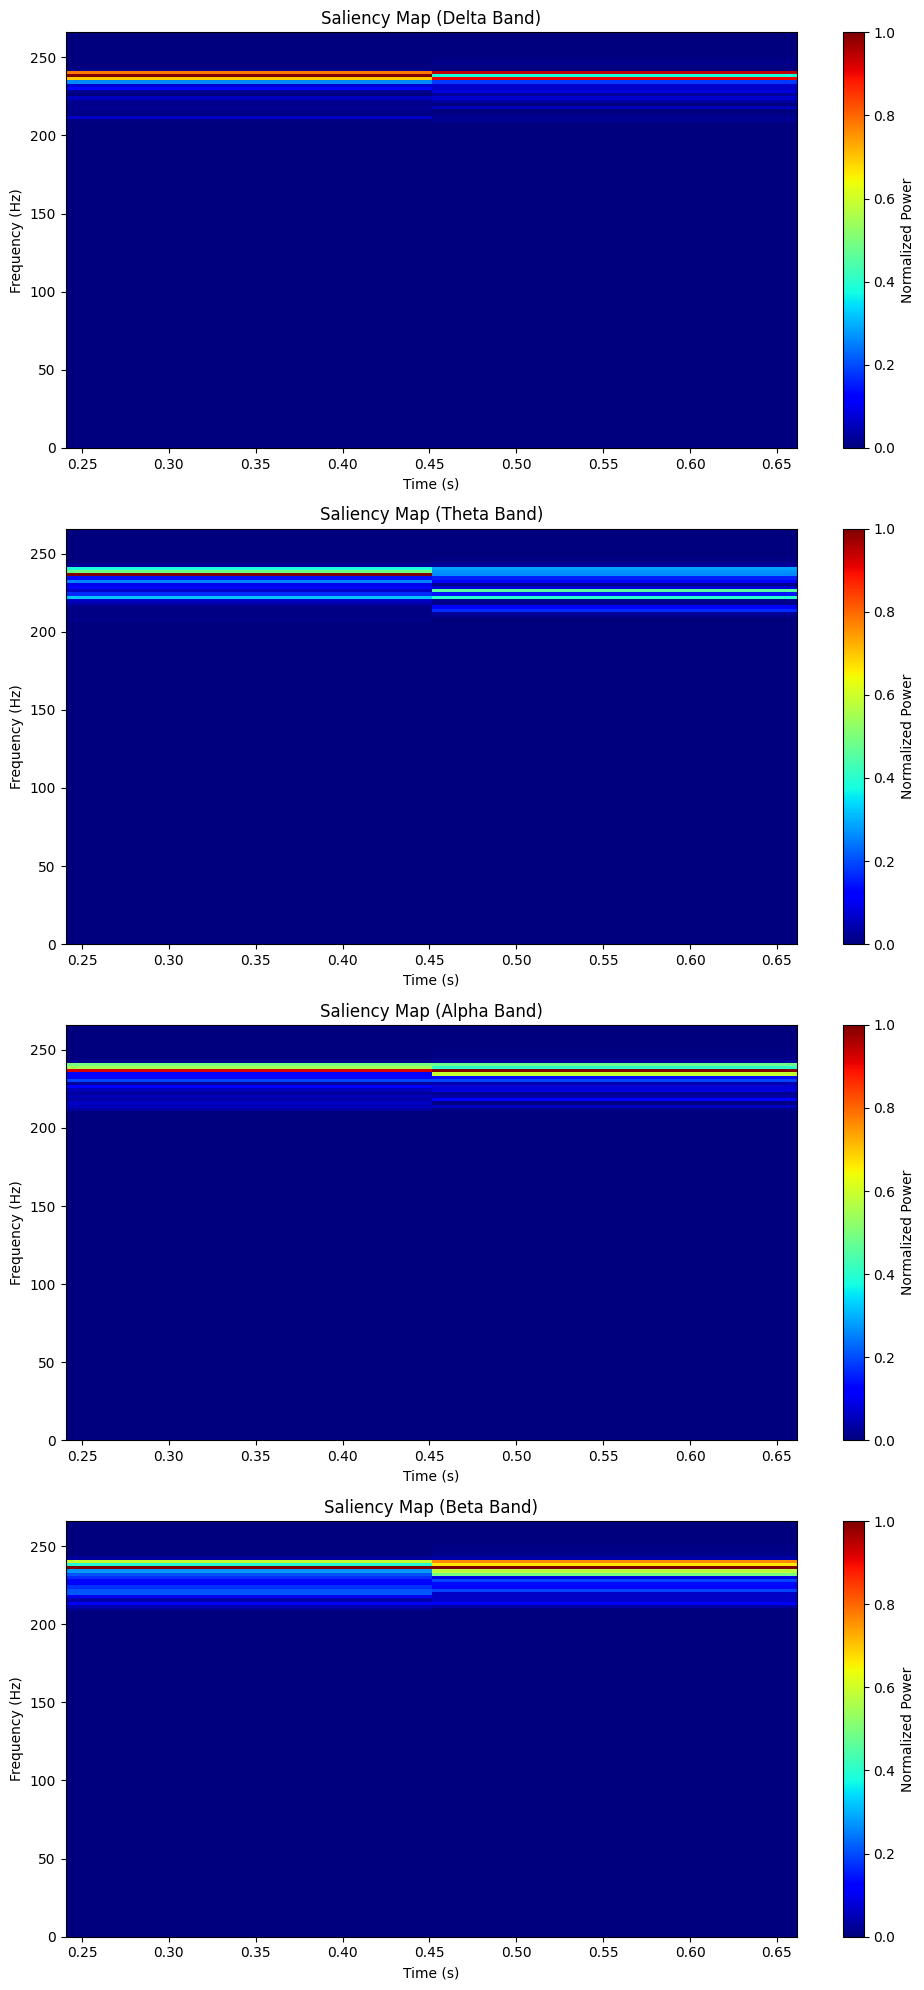

In [58]:
## Define frequency bands and labels
frequency_bands = [(1, 4), (4, 8), (8, 13), (13, 30)]  # Adjust as needed
band_labels = ['Delta', 'Theta', 'Alpha', 'Beta']  # Labels for each band

# Create a figure with subplots for each saliency map
fig, axes = plt.subplots(len(frequency_bands), 1, figsize=(10, 5 * len(frequency_bands)))

for i, (band, label) in enumerate(zip(frequency_bands, band_labels)):
    # Find the frequency indices that fall within the band
    band_indices = np.where((f >= band[0]) & (f <= band[1]))
    
    # Use the indices to extract the relevant data from Sxx
    band_power = np.mean(Sxx[band_indices], axis=0)
    
    # Normalize the power values (optional)
    band_power_normalized = (band_power - np.min(band_power)) / (np.max(band_power) - np.min(band_power))
    
    # Plot the saliency map in the corresponding subplot
    ax = axes[i]
    im = ax.imshow(band_power_normalized, cmap='jet', aspect='auto', extent=[t.min(), t.max(), f.min(), f.max()])
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Frequency (Hz)')
    ax.set_title(f'Saliency Map ({label} Band)')

    # Add a colorbar for each subplot
    cbar = fig.colorbar(im, ax=ax)
    cbar.set_label('Normalized Power')

# Adjust layout and display the figure
plt.tight_layout()
plt.show()

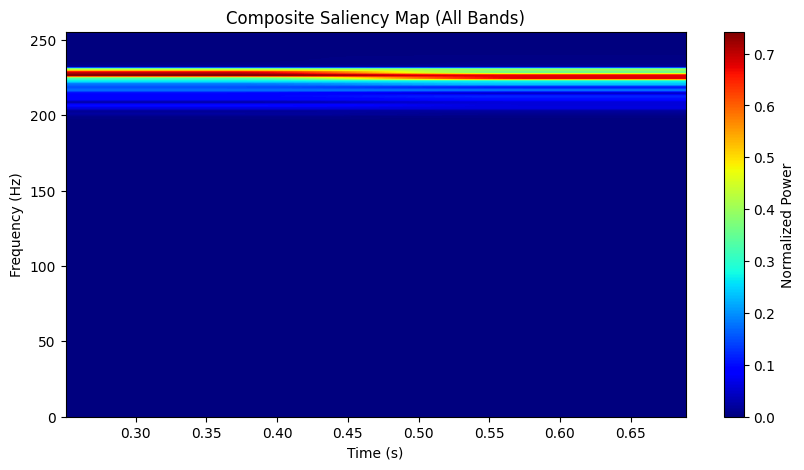

In [62]:
# Define the frequency bands
bands = {
    "Alpha": (8, 13),
    "Beta": (13, 30),
    "Theta": (4, 8),
    "Delta": (0.5, 4)
}

# Initialize an empty dictionary to store saliency maps for each band
saliency_maps = {}

for band_name, band_range in bands.items():
    # Apply the bandpass filter to the EEG data
    lowcut, highcut = band_range
    eeg_data = dataset[1]['eeg']
    fs = eeg_data.shape[1]
    
    # Calculate spectrogram features
    f, t, Sxx = spectrogram(eeg_data, fs=fs)
    
    # Compute the power in the current band
    band_indices = np.where((f >= lowcut) & (f <= highcut))
    band_power = np.mean(Sxx[band_indices], axis=0)
    
    # Normalize the power values (optional)
    band_power_normalized = (band_power - np.min(band_power)) / (np.max(band_power) - np.min(band_power))
    
    # Store the saliency map in the dictionary
    saliency_maps[band_name] = band_power_normalized

# Combine the saliency maps into a single composite map
composite_map = np.mean(list(saliency_maps.values()), axis=0)

# Plot the composite saliency map
plt.figure(figsize=(10, 5))
plt.imshow(composite_map, cmap='jet', aspect='auto', extent=[t.min(), t.max(), f.min(), f.max()])
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.title('Composite Saliency Map (All Bands)')
plt.colorbar(label='Normalized Power')
plt.show()

In [35]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [44]:
# Preprocessing: Standardize the EEG data
scaler = StandardScaler()
eeg_data_scaled = scaler.fit_transform(eeg_data)

# Feature extraction: Principal Component Analysis (PCA)
n_components = 30  # Number of components to keep
pca = PCA(n_components=n_components)
eeg_pca = pca.fit_transform(eeg_data)
print(len(eeg_pca))
print(eeg_pca)
# Calculate saliency scores (e.g., using variance of PCA components)
saliency_scores = np.var(eeg_pca, axis=1)

# Normalize saliency scores to the range [0, 1]
saliency_scores_normalized = (saliency_scores - np.min(saliency_scores)) / (np.max(saliency_scores) - np.min(saliency_scores))

# Reshape saliency scores to match the original EEG data shape
saliency_map = saliency_scores_normalized.reshape(eeg_data.shape[0], -1)

128
[[-6.26962579 -0.31875927  0.3322331  ...  0.60755605  0.33463121
  -0.59693232]
 [-4.78676592  0.06503037  0.57041815 ...  0.49710971 -0.1129256
  -0.05612759]
 [ 3.74468192  0.46756235 -0.23098593 ... -0.68556329  0.21982213
  -0.136328  ]
 ...
 [ 0.74765258 -0.33899066 -0.7223282  ... -0.15261687 -0.2324296
  -0.02676138]
 [-0.70461506 -0.25716094  0.50341115 ... -0.08987796  0.03574785
   0.07911392]
 [-0.9229178  -0.34733738  0.14133882 ... -0.05369743  0.01176703
   0.02380803]]


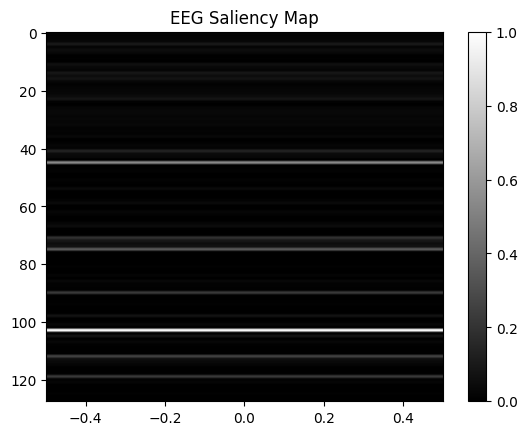

In [45]:
# Visualize the saliency map
plt.imshow(saliency_map, cmap='gray', aspect='auto')
plt.title('EEG Saliency Map')
plt.colorbar()
plt.show()

In [17]:
from scipy.signal import welch

# Compute spectral power using the Welch method
def compute_spectral_power(eeg_data, fs):
    f, Pxx = welch(eeg_data, fs=fs, nperseg=256)
    return f, Pxx

fs = eeg_data.shape[1] # Sampling frequency in Hz
print(fs)
freq, power = compute_spectral_power(eeg_data, fs)
def compute_saliency(power):
    return (power - np.min(power)) / (np.max(power) - np.min(power))

saliency_map = compute_saliency(power)


532


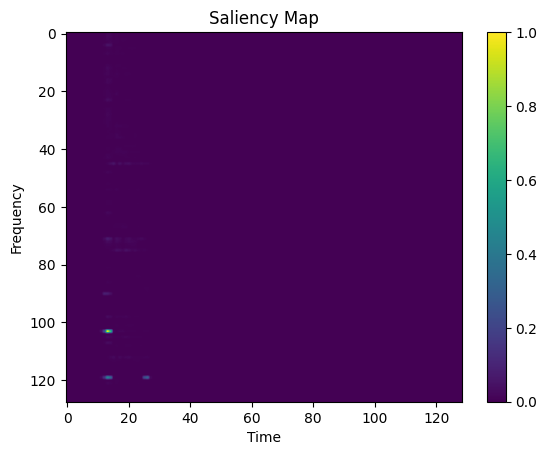

In [18]:
import matplotlib.pyplot as plt

# Plot the saliency map
plt.imshow(saliency_map, cmap='viridis', aspect='auto')
plt.colorbar()
plt.title('Saliency Map')
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.show()

In [46]:
import torch
import torch.nn.functional as F
import cv2
output_directory = '/media/mountHDD1/LanxHuyen/CVPR2017'
# Define constants
# input_shape = (512, 440, 3)  # Original EEG image shape
output_shape = (512, 440)  # Resized image shape

# Method 1: Creating grayscale heatmaps for each trial
def process_method_1(eeg_data,time_low=20, time_high=460, output_shape=(512, 440)):
    eeg_data = eeg_data[:, time_low:time_high]
    normalized_data = (eeg_data - eeg_data.min()) / (eeg_data.max() - eeg_data.min())
    grayscale_images = (normalized_data * 255).to(torch.uint8)
    grayscale_images = grayscale_images.unsqueeze(0).unsqueeze(0) # (1, 1, h, w)
    resized_images = F.interpolate(grayscale_images, size=(512, 440), mode='bilinear', align_corners=True)
    resized_images = resized_images.squeeze(0).squeeze(0)
    resized_images = torch.tensor(resized_images, dtype=torch.float32)
    return resized_images
# for i, eeg_data in enumerate(dataset):
#     if i==0:
#         eeg_data = eeg_data['eeg']
#         h, w = eeg_data.size()
#         normalized_data = (eeg_data - eeg_data.min()) / (eeg_data.max() - eeg_data.min())
#         grayscale_images = (normalized_data * 255).to(torch.uint8)
#         # print(grayscale_images.size()) 
#         grayscale_images = grayscale_images.unsqueeze(0).unsqueeze(0) # (1, 1, h, w)
#         # print(grayscale_images.size()) 
#         resized_images = F.interpolate(grayscale_images, size=(512, 440), mode='bilinear', align_corners=True)
#         resized_images = torch.tensor(resized_images, dtype=torch.float32)
#         print(resized_images)
# Apply method 1 to each tensor in eeg_tensors
for sample in dataset:
    sample['eeg'] = process_method_1(sample['eeg'])


/tmp/ipykernel_10779/2903703738.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  resized_images = torch.tensor(resized_images, dtype=torch.float32)


[[136. 135. 133. ... 124. 123. 123.]
 [135. 134. 132. ... 123. 122. 123.]
 [133. 133. 131. ... 122. 122. 122.]
 ...
 [125. 125. 125. ... 126. 126. 126.]
 [125. 125. 125. ... 125. 125. 126.]
 [124. 124. 124. ... 125. 125. 126.]]


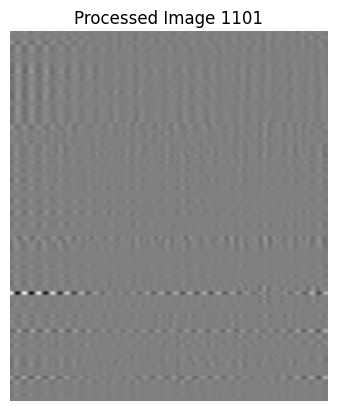

In [47]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming you have already processed the images using the process_method_1 function
# processed_images = [process_method_1(eeg_tensor) for eeg_tensor in eeg_tensors]

# Choose the index of the image you want to plot (e.g., index 0)
image_index = 1100

# Convert the processed image to a numpy array and transpose dimensions
# numpy_image = processed_images[image_index].numpy().transpose(1, 2, 0)
numpy_image = dataset[image_index]['eeg'].numpy()
print(numpy_image)

# Plot the processed image
plt.imshow(numpy_image, cmap='gray')  # Display as grayscale
plt.title(f"Processed Image {image_index + 1}")
plt.axis('off')
plt.show()

In [ ]:
import numpy as np
eeg_length = np.zeros(len(dataset))
for i in range(len(dataset)):
    eeg_length[i] = list(dataset[i]['eeg'].size())[1]

In [ ]:
sub_length = np.empty(len(dataset))
for i in range(len(dataset)):
    sub_length[i] = dataset[i]['subject']

In [ ]:
# print(dataset['eeg'].size())
import torch.nn.functional as F
desired_size = 500

new_dataset = torch.zeros(len(dataset), 128, desired_size)

for i in range(len(dataset)):
    eeg_data = dataset[i]['eeg']

    # Convert the tensor to torch.float32
    eeg_data_float = eeg_data.to(torch.float32)

    # Resize using linear interpolation
    resized_eeg = F.interpolate(eeg_data_float.unsqueeze(0), size=desired_size, mode='linear')

    # Convert the resized tensor back to the original data type (if needed)
    resized_eeg = resized_eeg.to(eeg_data.dtype)

    new_dataset[i, :, :] = resized_eeg.squeeze(0)

In [ ]:
new_dataset.size()

In [ ]:
for j in range(1996):
    filtered_dataset_4 = new_dataset[j]
for k in range(1996,3980):
    filtered_dataset_1 = new_dataset[k]
for l in range(3981,5976):
    filtered_dataset_6 = new_dataset[l]
for m in range(5977,7972):
    filtered_dataset_3 = new_dataset[m]
for n in range(7973,9968):
    filtered_dataset_2 = new_dataset[n]
for o in range(9969,11964):
    filtered_dataset_5 = new_dataset[o]

In [ ]:
print(filtered_dataset_4.size())
print(filtered_dataset_1.size())
print(filtered_dataset_6.size())
print(filtered_dataset_3.size())
print(filtered_dataset_2.size())
print(filtered_dataset_5.size())

In [ ]:
filtered_dataset = torch.stack((filtered_dataset_4,filtered_dataset_1,filtered_dataset_6,filtered_dataset_3,filtered_dataset_2,filtered_dataset_5),dim = 0)

In [ ]:
filtered_dataset.size()

In [ ]:
print(filtered_dataset)

In [ ]:
# for i in range(len(new_dataset)):
#     image_index = dataset[i]['image']
#     subject_index = dataset[i]['subject']
#     filtered_dataset[subject_index-1, :, :] = new_dataset[image_index]

In [ ]:
keys = ('eeg', 'images', 'label')
for i in range(len(new_dataset)):
    value = (filtered_dataset, dataset

In [ ]:
# for i in range(len(dataset)):
#     # Normalize each component using mean and stddev
#    new_dataset[i, :, :] = (new_dataset[i, :, :] - means) / stddevs

In [ ]:
# print(new_dataset.size())
# print(new_dataset[0])

# import matplotlib.pyplot as plt
# plt.plot(new_dataset[0][0])

In [ ]:
heatmap_image = filtered_dataset

In [ ]:
heatmap_image.size()

In [ ]:
# Normalize the heatmap image to [0, 255]
heatmap_image_normalized = ((heatmap_image - heatmap_image.min()) /
                            (heatmap_image.max() - heatmap_image.min()) * 255).byte()

In [ ]:
# Convert the tensor to a NumPy array for plotting
heatmap_image_np = heatmap_image_normalized.numpy()

# Display the heatmap image
plt.imshow(heatmap_image_np, cmap='gray')
plt.title("EEG Grayscale Heatmap Image")
plt.colorbar()
plt.show()

In [ ]:
print(heatmap_image_np)
print(heatmap_image_np.shape)

In [ ]:
for i in range(len(dataset)):
    dataset[i]['eeg'] = new_dataset[i]

In [ ]:
print(dataset[2])

In [ ]:
opt = {
    # Dataset options
#     "iv": "image",
#     "offset": None,
    "results_file": "results.pkl",
    "subject": 0,
    "time_low": 20,
    "time_high": 460,
#     "run": "none",
    "eeg_dataset": eeg_dataset,
    "model_type": "model10",
    "splits_path": splits_all_path,
    "split_num": 0,
    "split_name": "train",
#     "fold": 5,
    #Training options
    "batch_size": 16,
    "optim": "Adam",
    "learning_rate": 0.001,
    "learning_rate_decay_by": 0.5,
    "learning_rate_decay_every": 10,
    "epochs": 100,
    "GPUindex": 0,
    "kind":"from-scratch",
    #Backend options
    "no_cuda": False,
    "classifier": None
}
opt = argparse.Namespace(**opt)
print(opt)

In [ ]:
%load_ext autoreload
%autoreload 2
from torch.utils.data import DataLoader
# from data_loader import EEGDataset, Splitter, SplitterWithData
from data_loader_CVPR2017 import EEGDataset, Splitter
from EEG_Encoder.LSTM import classifier_LSTM
from EEG_Encoder.CNN import classifier_CNN
from EEG_Encoder.EEGNet import classifier_EEGNet
from EEG_Encoder.SyncNet import classifier_SyncNet
from EEG_Encoder.EEGChannelNet import classifier_EEGChannelNet
from EEG_Encoder.net_generator import Classifier
from EEG_Encoder.net_trainer import net_trainer
from p_values import *
from torchinfo import summary

In [ ]:
def load_dataset(
#              offset,
             eeg_dataset,
             splits_path,
             split_num, # (0-5) - 6 fold cross validation
#              total, 
#              classes,
#              classifier,
             batch_size,
#              GPUindex,
#              length, # 500
#              channel, # 128
#              min_CNN,
             opt,
             kind="from-scratch"):        
    # Load dataset
    dataset = EEGDataset(opt, eeg_dataset)
    print("DONE: LOAD DATASET")
#     # Create loaders for LSTM/MLP/CNN/SCNN/EEGNet/SyncNet/EEGChannelNet
#     if kind=="from-scratch":
#         relabel = False
#     if kind=="incremental":
#         relabel = False
#     if kind=="no-model-file":
#         relabel = True
    splitter = {split: Splitter(dataset,
                    splits_path,
                    split_num,
                    split_name=split) for split in ["train", "val", "test"]}
    loaders = {split: DataLoader(
                        splitter[split],
                        batch_size = batch_size,
                        drop_last = False,
                        shuffle = True)
                    for split in ["train", "val", "test"]}
    channel_idx = None    
    print("DONE: Create loaders for model")            
    return dataset, loaders, splitter

In [ ]:
# Options
opt.classifier = "LSTM4"
opt.batch_size = 16
# opt.kind = "from-scratch"
# opt.run = "imagenet40-1000"
# opt.fold = 5

In [ ]:
dataset, loaders, splitter = load_dataset(
#              offset,
             opt.eeg_dataset,
             opt.splits_path,
             opt.split_num, # (0-5) - 6 fold cross validation
#              total, 
#              classes,
#              classifier,
             opt.batch_size,
#              GPUindex,
#              length, # 500
#              channel, # 128
#              min_CNN,
             opt,
             opt.kind)

In [ ]:
# loaders: divide the splits data in each fold with batch_size
# Each fold has {train: 8000 idx, val: 2000 idx, test: 2000 idx}
# Each loader batch has {train: 2000 idx, val: 250 idx, test: 250 idx}
print(type(dataset))
print(type(loaders))
print(len(loaders), [len(loaders[name]) for name in ["train", "val", "test"] ])
# for i, (input, target) in enumerate(loaders["train"]):
#     if i<20:
#         print(f"{i+1}: Target size: {target.size()}; input size: {input.size()}")
for i in range(0, 40):
    eeg, label_val = splitter["val"][i]
    eeg, label_train = splitter["train"][i]
    print(f"{i+1}: Label val: {label_val}; label train: {label_train}")


In [ ]:
net, nonclasses = Classifier(
                 n_classes,
                 classes,
                 opt.classifier,
                 opt.GPUindex,
                 length,
                 channel,
                 min_CNN,
                 opt.kind)
# print(len(nonclasses))
summary(net, input_size=(1,128, 440))

In [ ]:
model_path = (   "CVPR2017-" +
                  opt.classifier+
                  "-"+
                  str(length)+
                  "-"+
                  str(channel)+
                  "-"+
                  'Retest' )
print(model_path)

In [ ]:
print(opt)

In [ ]:
channel_idx=None
non_classes=None
if opt.kind=="from-scratch":
    results = net_trainer(
            net,
            loaders,
            opt,
            channel_idx,
            nonclasses,
            None,
            True,
            model_path,
            print_every_train = 100,
            print_every_val = 125)

Train Batch 100 (every 100 batch): Loss=0.1550; accuracy=0.9006
Train Batch 200 (every 100 batch): Loss=0.3906; accuracy=0.9047
Train Batch 300 (every 100 batch): Loss=0.3261; accuracy=0.9083
Train Batch 400 (every 100 batch): Loss=0.6428; accuracy=0.9066
Epoch 47 summary: train_loss: 0.3177 | train_acc: 0.9004 | val_loss: 4.7394 | val_acc: 0.2010
Epoch 48
Train Batch 100 (every 100 batch): Loss=0.1733; accuracy=0.9169
Train Batch 200 (every 100 batch): Loss=0.3384; accuracy=0.9178
Train Batch 300 (every 100 batch): Loss=0.1867; accuracy=0.9167
Train Batch 400 (every 100 batch): Loss=0.6507; accuracy=0.9172
Epoch 48 summary: train_loss: 0.2767 | train_acc: 0.9110 | val_loss: 4.8376 | val_acc: 0.2001
Epoch 49
Train Batch 100 (every 100 batch): Loss=0.4388; accuracy=0.9013
Train Batch 200 (every 100 batch): Loss=0.1834; accuracy=0.8944
Train Batch 300 (every 100 batch): Loss=0.8391; accuracy=0.8906
Train Batch 400 (every 100 batch): Loss=0.2250; accuracy=0.8869
Epoch 49 summary: train_lo

Train Batch 100 (every 100 batch): Loss=0.4704; accuracy=0.8187
Train Batch 200 (every 100 batch): Loss=0.2372; accuracy=0.8181
Train Batch 300 (every 100 batch): Loss=0.2904; accuracy=0.8152
Train Batch 400 (every 100 batch): Loss=0.2112; accuracy=0.8194
Epoch 70 summary: train_loss: 0.5636 | train_acc: 0.8289 | val_loss: 5.8814 | val_acc: 0.2016
Epoch 71
Train Batch 100 (every 100 batch): Loss=0.3092; accuracy=0.9256
Train Batch 200 (every 100 batch): Loss=0.3137; accuracy=0.9300
Train Batch 300 (every 100 batch): Loss=0.0731; accuracy=0.9383
Train Batch 400 (every 100 batch): Loss=0.2065; accuracy=0.9442
Epoch 71 summary: train_loss: 0.1714 | train_acc: 0.9450 | val_loss: 5.7815 | val_acc: 0.2046
Epoch 72
Train Batch 100 (every 100 batch): Loss=0.0299; accuracy=0.9656
Train Batch 200 (every 100 batch): Loss=0.0485; accuracy=0.9716
Train Batch 300 (every 100 batch): Loss=0.0297; accuracy=0.9727
Train Batch 400 (every 100 batch): Loss=0.0633; accuracy=0.9722
Epoch 72 summary: train_lo

Train Batch 100 (every 100 batch): Loss=0.0293; accuracy=0.9712
Train Batch 200 (every 100 batch): Loss=0.0162; accuracy=0.9678
Train Batch 300 (every 100 batch): Loss=0.1756; accuracy=0.9677
Train Batch 400 (every 100 batch): Loss=0.0787; accuracy=0.9627
Epoch 93 summary: train_loss: 0.1430 | train_acc: 0.9585 | val_loss: 6.7716 | val_acc: 0.2149
Epoch 94
Train Batch 100 (every 100 batch): Loss=0.0577; accuracy=0.9700
Train Batch 200 (every 100 batch): Loss=0.1885; accuracy=0.9656
Train Batch 300 (every 100 batch): Loss=0.1342; accuracy=0.9652
Train Batch 400 (every 100 batch): Loss=0.3027; accuracy=0.9586
Epoch 94 summary: train_loss: 0.1505 | train_acc: 0.9534 | val_loss: 7.1981 | val_acc: 0.1959
Epoch 95
Train Batch 100 (every 100 batch): Loss=0.1803; accuracy=0.9500
Train Batch 200 (every 100 batch): Loss=0.0802; accuracy=0.9528
Train Batch 300 (every 100 batch): Loss=0.0852; accuracy=0.9508
Train Batch 400 (every 100 batch): Loss=0.0628; accuracy=0.9506
Epoch 95 summary: train_lo

In [ ]:
# val = results["val_acc"]
# # test = results["test_acc"]

# print("Validation accuracy: ", val)
# # print("Test accuracy: ", test)

In [ ]:
print(accuracy_val)